In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,accuracy_score
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score

In [ ]:
""" READ ME
Content:
first cell holds the functions
in the next cell the functions are run,
after that results are printed
after that some remarks are made regarding the data
"""

In [141]:
from sklearn.model_selection import KFold


class DataAnalyzer:
    def __init__(self):

        base_folder = 'mushroom'
        mushrooms_data = pd.read_csv(f'{base_folder}/agaricus-lepiota.data')  # Assuming it's tab-separated
        self.description_file = f'{base_folder}/agaricus-lepiota.names'
        self.dataset = mushrooms_data

        self.original_dataset = self.dataset
        self.fill_nan_vals()
        self.encode_categorical()
        self.dataset = self.dataset.drop("p.2", axis=1)

        self.X_train, self.y_train, self.X_cv, self.X_test_final, self.y_cv, self.y_test_final = None, None, None, None, None, None

  
    def fill_nan_vals(self):
        for column in self.dataset.columns:
            if self.dataset[column].dtype == 'object':  # Non-numerical column
                mode_val = self.dataset[column].mode()[0]
                self.dataset[column] = self.dataset[column].fillna(mode_val)
            else:  # Numerical column
                mean_val = self.dataset[column].mean()
                self.dataset[column] = self.dataset[column].fillna(mean_val)

    def drop_nan_vals(self):
        self.dataset = self.dataset.dropna()
        
    def encode_categorical(self):
        label_encoder = LabelEncoder()
        for column in self.dataset.columns:
            if self.dataset[column].dtype == 'object':  # Check if column is categorical
                encoded_values = label_encoder.fit_transform(self.dataset[column])
                self.dataset[column] = encoded_values


    def show_boxplots(self):
        fig, axs = plt.subplots(ncols=7, nrows=4, figsize=(20, 10))
        index = 0
        axs = axs.flatten()
        for k,v in self.dataset.items():
            sns.boxplot(y=k, data=self.dataset, ax=axs[index])
            index += 1
        plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

    def show_outlier_percs(self):
        for k, v in self.dataset.items():
            q1 = v.quantile(0.25)
            q3 = v.quantile(0.75)
            irq = q3 - q1
            v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
            perc = np.shape(v_col)[0] * 100.0 / np.shape(self.dataset)[0]
            print("Column %s outliers = %.2f%%" % (k, perc))

    def remove_outliers(self):
        self.dataset = self.dataset[~((self.dataset['stage'] > 7.0) | (self.dataset['stage'] < 4.0))]
        return self.datase

    def normalize_df_by_max(self):
        normalized_df = self.dataset.copy()
        for column in self.dataset.columns[:-1]:  # Exclude the last column
            max_abs_value = abs(self.dataset[column]).max()
            normalized_df[column] = self.dataset[column] / max_abs_value

        self.dataset = normalized_df
        return(self.dataset)

    def normalize_df_by_mean(self):
        sc = StandardScaler()
        self.X_train = sc.fit_transform(self.X_train)
        self.X_test_final = sc.transform(self.X_test_final)
        if self.X_cv is not None:
            self.X_cv = sc.fit_transform(self.X_cv)
        return(self.X_train, self.X_test_final, self.X_cv)
    
    def show_histplots(self):
        fig, axs = plt.subplots(ncols=7, nrows=4, figsize=(20, 10))
        index = 0
        axs = axs.flatten()
        for k,v in self.dataset.items():
            sns.histplot(v, ax=axs[index])
            index += 1
        plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

    def show_heat_map(self):
        plt.figure(figsize=(20, 10))
        sns.heatmap(self.dataset.corr().abs(),  annot=True)

    def plot_variations(self):
        min_max_scaler = preprocessing.MinMaxScaler()
        column_sels = self.dataset.columns
        x = self.dataset.loc[:,column_sels]
        y = self.dataset['p']
        # x = pd.DataFrame(data=min_max_scaler.fit_transform(x), columns=column_sels)
        fig, axs = plt.subplots(ncols=4, nrows=6, figsize=(20, 10))
        index = 0
        axs = axs.flatten()
        for i, k in enumerate(column_sels):
            sns.regplot(y=y, x=x[k], ax=axs[i])
        plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

    def get_x_and_Y(self):
        self.X = self.dataset.drop('p', axis=1)  # Assuming 'p' is the target variable
        self.y = self.dataset['p']
        return (self.X, self.y)

    
    def perform_manual_splitting_cv(self):
        # First split to get training set and first test set
        self.X_train, X_temp, self.y_train, y_temp = train_test_split(self.X, self.y, test_size=0.4, random_state=0)

        # Second split to further split the temporary test set into the second test set
        self.X_cv, self.X_test_final, self.y_cv, self.y_test_final = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)

    def perform_knn(self):
        self.classifier = KNeighborsClassifier(n_neighbors = 20, metric = 'minkowski', p = 2.7)
        self.classifier.fit(self.X_train, self.y_train)
        y_pred1 = self.classifier.predict(self.X_cv)
        self.ac_cv = accuracy_score(self.y_cv,y_pred1)
        return self.ac_cv
    
    def get_accuracy(self):
        y_pred_final = self.classifier.predict(self.X_test_final)
        self.ac_final = accuracy_score(self.y_test_final,y_pred_final)
        return self.ac_final

    
    def perform_kfold_cv(self):
        X_train, X_test_final, y_train, y_test_final = train_test_split(self.X, self.y, test_size=0.2, random_state=0)
        self.X_train = X_train
        self.y_train = y_train
        self.X_test_final = X_test_final.reindex(X_train.columns, axis=1)
        self.y_test_final = y_test_final
        classifier = KNeighborsClassifier(n_neighbors = 40, metric = 'minkowski', p = 2.7)

        # Perform k-fold cross-validation
        kf = KFold(n_splits=5, shuffle=True, random_state=0)

        scores = []
        best_model = None
        best_avg_score = 0.0 

        for train_index, val_index in kf.split(X_train):
            X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
            y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

            # Train the model on the training fold
            classifier.fit(X_train_fold, y_train_fold)

            # Evaluate the model on the validation fold
            score = classifier.score(X_val_fold, y_val_fold)

            # Update the best model if the current model has a better average performance
            if score > best_avg_score:
                best_avg_score = score
                best_model = classifier
            scores.append(score)
        
        self.classifier = best_model
        return(best_avg_score, scores)

class Master:
    def __init__(self):
        self.results = {}
        
    def organize_results(self):
        items = []
        for k, v in self.results.items():
            print(k, v)
            if isinstance(v, dict):
                for xk, xv in v.items():
                    new_x_key = xk
                    items.append((new_x_key, xv))
            else:
                new_key = k
                items.append((new_key, v))
        r_items = dict(items)
        df = pd.DataFrame({'method': list(r_items.keys()), 'result': list(r_items.values())})
        return df

    def run_raw(self):
        anlyzr = DataAnalyzer()
        anlyzr.get_x_and_Y()
        anlyzr.perform_manual_splitting_cv()
        anlyzr.perform_knn()
        self.results["raw_run"] = anlyzr.get_accuracy()

    def run_after_max_normalisation(self):
        anlyzr = DataAnalyzer()
        anlyzr.normalize_df_by_max()
        anlyzr.get_x_and_Y()
        anlyzr.perform_manual_splitting_cv()
        anlyzr.perform_knn()
        self.results["after_max_normalisation_run"] = anlyzr.get_accuracy()

    def run_after_mean_normalisation(self):
        anlyzr = DataAnalyzer()
        anlyzr.get_x_and_Y()
        anlyzr.perform_manual_splitting_cv()
        anlyzr.normalize_df_by_mean()
        anlyzr.perform_knn()
        self.results["after_mean_normalisation_run"] = anlyzr.get_accuracy()

    def run_with_kfold(self):
        anlyzr = DataAnalyzer()
        anlyzr.normalize_df_by_max()
        anlyzr.get_x_and_Y()
        (best_avg_score, scores) = anlyzr.perform_kfold_cv()
        self.results["after_k_fold_run"] = {
            "best_cv_score": best_avg_score,
            "scores": scores,
            "final_score": anlyzr.get_accuracy()
        }
    
    def run(self):
        self.run_raw()
        self.run_after_max_normalisation()
        self.run_after_mean_normalisation()
        self.run_with_kfold()
        return self.results


In [139]:
anlyzr = DataAnalyzer()

In [142]:
mstr = Master()
results = mstr.run()

In [143]:
results_df = mstr.organize_results()
display(results_df)

raw_run 0.976
after_max_normalisation_run 0.9981538461538462
after_mean_normalisation_run 0.9895384615384616
after_k_fold_run {'best_avg_score': 0.9946153846153846, 'scores': [0.9923076923076923, 0.9946153846153846, 0.9946153846153846, 0.9923017705927637, 0.9861431870669746], 'final_score': 0.9870769230769231}


,method,result
0,raw_run,0.976
1,after_max_normalisation_run,0.998154
2,after_mean_normalisation_run,0.989538
3,best_avg_score,0.994615
4,scores,"[0.9923076923076923, 0.9946153846153846, 0.994..."
5,final_score,0.987077


In [ ]:
"""
There was not much difference in applying different methods to this data set, there is a possibility, that one of the variables is highly correlated, or there is a chance of overfittion

"""

In [ ]:

anlyzr = DataAnalyzer()


In [ ]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
display(anlyzr.dataset[6000:-1])
test_df2 = anlyzr.dataset

test_df2.to_csv('output2.csv', index=False)

In [ ]:
len(test_df2[test_df2['p'] == 1])

In [ ]:
anlyzr.plot_variations()

In [ ]:
anlyzr.plot_variations()

In [ ]:
anlyzr.get_x_and_Y()



In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
display(anlyzr.dataset)

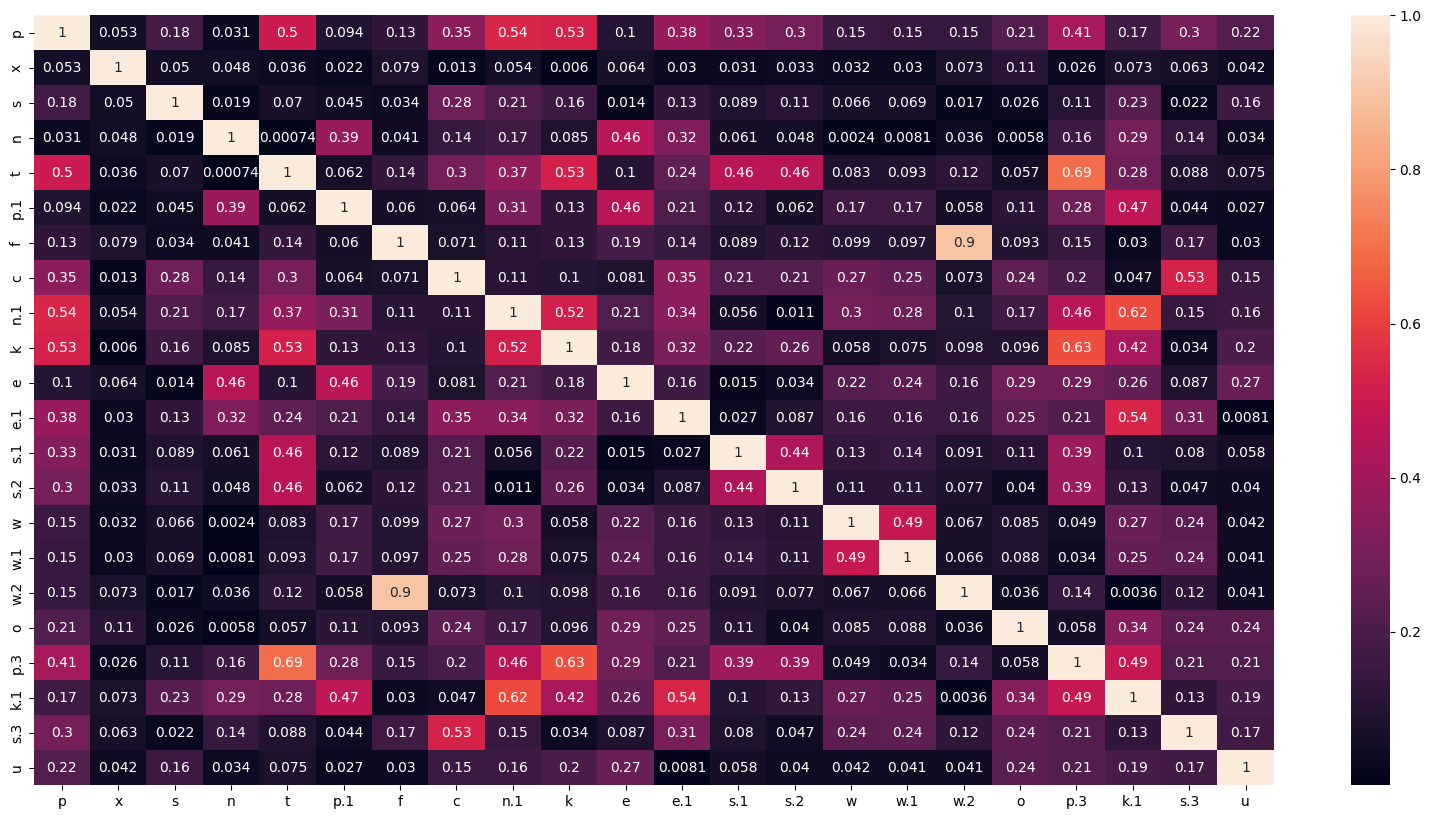

In [51]:
anlyzr.show_heat_map()

In [ ]:
anlyzr.show_boxplots()